## 1. Постановка задачи

<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 
import socket
socket

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

Произведем базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


In [2]:
data = pd.read_csv(
    "data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Данные описываются следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


In [5]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# временные границы предоставленных данных
print(data['InvoiceDate'].min(), '-', data['InvoiceDate'].max())

2010-12-01 08:26:00 - 2011-12-09 12:50:00


## 3. Предобработка и очистка данных

Подготовим датасет для дальнейшего моделирования, произведя очистку данных.


In [6]:
data = data.dropna(axis=0)
data.shape

(406829, 8)

In [7]:
print('Количество полных дубликатов в записях:', data.duplicated().sum())
data.drop_duplicates(inplace=True)

Количество полных дубликатов в записях: 5225


В столбце с количеством товара есть отрицательные значения. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [8]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number: {}'.format(negative_quantity.shape[0]))
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [9]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавляем в вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.


In [10]:
nb_products_per_basket['order_canceled'] = 0
index = 0

for elem in nb_products_per_basket['InvoiceNo']:
    if elem[0] == 'C':
        nb_products_per_basket['order_canceled'][index] = 1
    else:
        nb_products_per_basket['order_canceled'][index] = 0
    index += 1

nb_products_per_basket

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0
...,...,...,...,...
22185,18283,579673,50,0
22186,18283,580872,50,0
22187,18287,554065,29,0
22188,18287,570715,38,0


Отмененные заказы:


In [11]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [12]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Гипотеза: для каждой отменённой транзакцию в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

Приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [13]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров вы не найдёте. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Гипотеза: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.


In [14]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара).

In [15]:
def get_quantity_canceled(data):
    """Принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, 
    в котором указано количество возвращённого впоследствии товара для каждой транзакции. 
    На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled
    """
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

In [16]:
data['QuantityCanceled'] = quantity_canceled
data['QuantityCanceled'].sum()

245266.0

In [17]:
data = data[data['Quantity'] >= 0]
data.shape

(392732, 9)

Следующая проблема — это специальные виды транзакций. Ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. 

In [18]:
data_qc = data[data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]
len(data_qc['StockCode'].unique())

6

In [19]:
data = data.drop(data_qc.index)

Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 


In [20]:
data_up = data[data['UnitPrice'] == 0]
data = data.drop(data_up.index)

## 4. Разведывательный анализ данных

Задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


In [21]:
popular_country = data.groupby('Country', as_index=False)['InvoiceNo'].nunique()

Text(0.5, 1.0, 'Количество уникальных клиентов по странам')

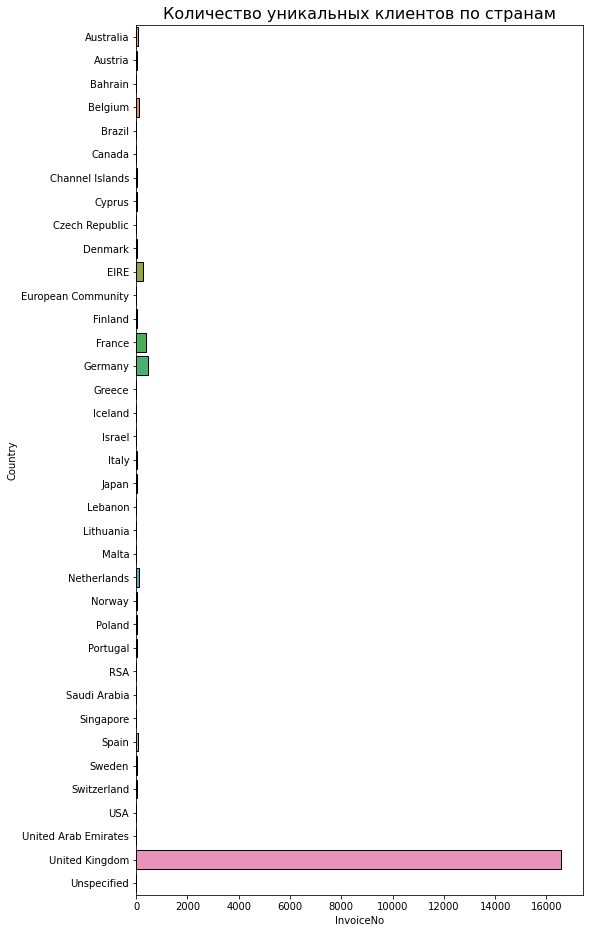

In [22]:
plt.figure(figsize=(8, 16))
popular_country_sns = sns.barplot(data=popular_country, x='InvoiceNo', y='Country')
popular_country_sns.axes.set_title('Количество уникальных клиентов по странам', fontsize=16)

In [23]:
stockcode_country = data.groupby('Country', as_index=False)['StockCode'].count()

Text(0.5, 1.0, 'Количество уникальных заказов по странам')

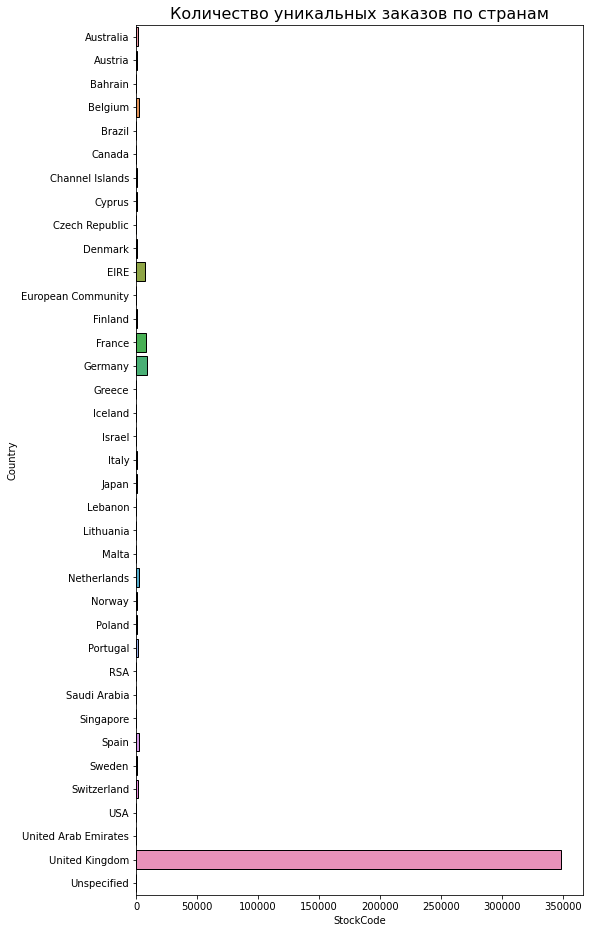

In [24]:
plt.figure(figsize=(8, 16))
stockcode_country_sns = sns.barplot(data=stockcode_country, x='StockCode', y='Country')
stockcode_country_sns.axes.set_title('Количество уникальных заказов по странам', fontsize=16)

Добавим в датасет общую цену заказа, назовём её TotalPrice.

In [25]:
data['TotalPrice'] = data['UnitPrice'] * ((data['Quantity']) - data['QuantityCanceled'])

In [26]:
totalprice_country = data.groupby('Country', as_index=False)['TotalPrice'].sum()

Text(0.5, 1.0, 'Страны по общему количеству выручки')

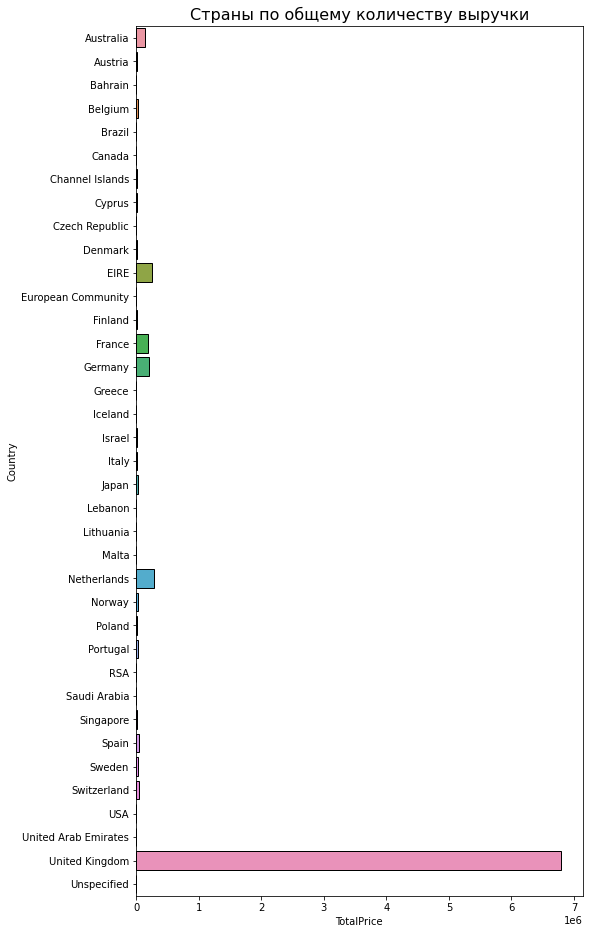

In [27]:
plt.figure(figsize=(8, 16))
totalprice_country_sns = sns.barplot(data=totalprice_country, x='TotalPrice', y='Country')
totalprice_country_sns.axes.set_title('Страны по общему количеству выручки', fontsize=16)

In [28]:
def add_datetime_features(df):
    """Функция принимает на вход таблицу с данными о поездках и возвращает ту же таблицу с добавленными в нее 3 столбцами:
    
    InvoiceMonth - месяц совершения покупки;
    InvoiceHour - час совершения покупки;
    InvoiceDayName - месяц совершения покупки.

    Args:
        df (Series): признак InvoiceDate

    Returns:
        DataFrame: датасет с тремя новыми признаками
    """
    
    df['InvoiceMonth'] = df['InvoiceDate'].dt.month
    df['InvoiceHour'] = df['InvoiceDate'].dt.hour
    df['InvoiceDayName'] = df['InvoiceDate'].dt.day_name()
    return df

add_datetime_features(data)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,InvoiceMonth,InvoiceHour,InvoiceDayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,12,8,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,8,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00,12,8,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,8,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,8,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,0.0,10.20,12,12,Friday
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,0.0,12.60,12,12,Friday
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,0.0,16.60,12,12,Friday
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,0.0,16.60,12,12,Friday


Text(0.5, 1.0, 'Суммарная выручка по месяцам')

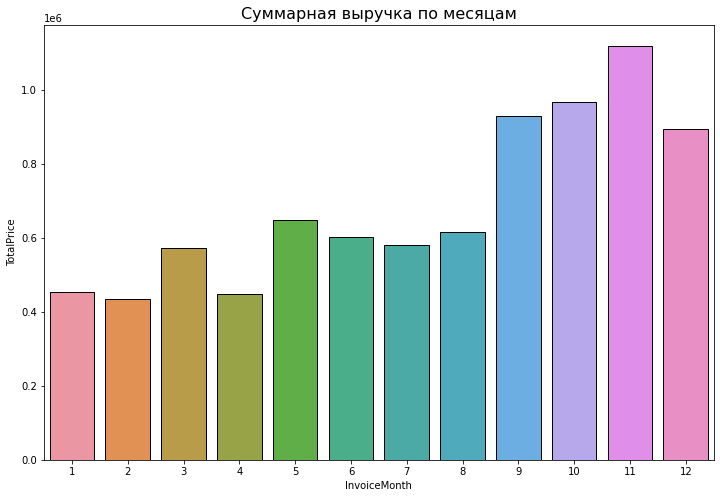

In [29]:
totalprice_from_month = data.groupby('InvoiceMonth', as_index=False)['TotalPrice'].sum()

plt.figure(figsize=(12, 8))
totalprice_from_month_sns = sns.barplot(data=totalprice_from_month, y='TotalPrice', x='InvoiceMonth')
totalprice_from_month_sns.axes.set_title('Суммарная выручка по месяцам', fontsize=16)

In [30]:
day_from_quantity = data.groupby('InvoiceDayName', as_index=False)['Quantity'].mean()
day_from_quantity

,InvoiceDayName,Quantity
0,Friday,14.977252
1,Monday,11.958929
2,Sunday,7.539094
3,Thursday,14.545904
4,Tuesday,15.314028
5,Wednesday,14.133571


Text(0.5, 1.0, 'Среднее количество заказов по дням')

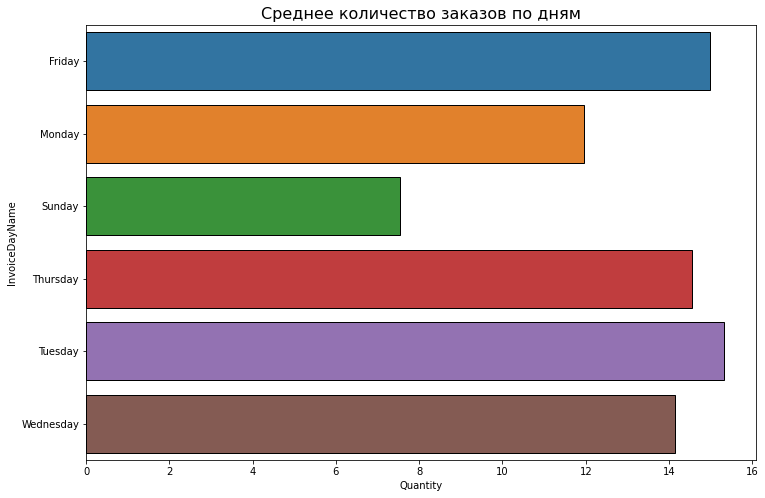

In [31]:
plt.figure(figsize=(12, 8))
day_from_quantity_sns = sns.barplot(data=day_from_quantity, x='Quantity', y='InvoiceDayName')
day_from_quantity_sns.axes.set_title('Среднее количество заказов по дням', fontsize=16)

In [32]:
data['InvoiceDateDay'] = data['InvoiceDate'].dt.date

date_hour_quantity = data.groupby(['InvoiceDateDay', 'InvoiceHour'], as_index=False)['Quantity'].mean()
date_hour_quantity = date_hour_quantity.groupby('InvoiceHour', as_index=False)['Quantity'].mean()

Text(0.5, 1.0, 'Распределение среднего количества ежедневно поступающих заказов по времени суток')

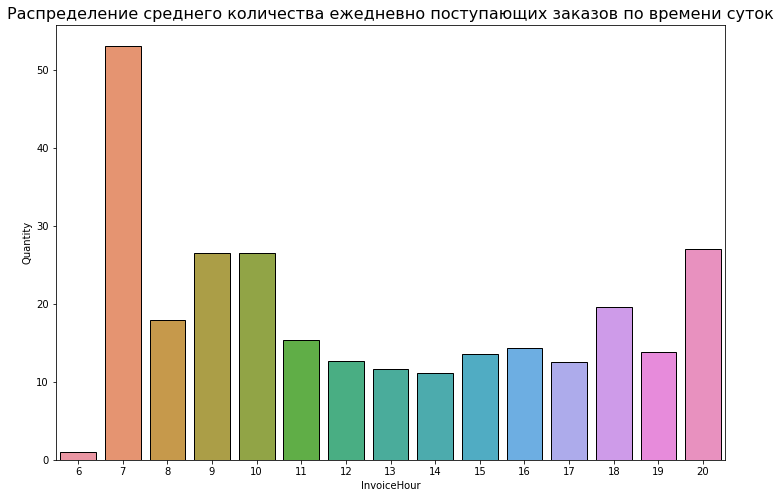

In [33]:
plt.figure(figsize=(12, 8))
date_hour_quantity_sns = sns.barplot(data=date_hour_quantity, x='InvoiceHour', y='Quantity')
date_hour_quantity_sns.axes.set_title('Распределение среднего количества ежедневно поступающих заказов по времени суток', fontsize=16)

## 5. RFM-сегментация клиентов: часть 1

Сформируем признаки, на основе которых мы будем производить сегментацию клиентов.

Воспользуемся методом для анализа потребительской ценности RFM. 

Группируем клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.

In [34]:
first_date = pd.to_datetime('2011-12-9')

rfm_table = data.groupby('CustomerID').agg(Recency=('InvoiceDate', 'max'),
                                           Frequency=('InvoiceNo', 'nunique'),
                                           Monetary=('TotalPrice', 'sum')
                                           )

rfm_table['Recency'] = abs((rfm_table['Recency'] - first_date).dt.days)
rfm_table

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


In [35]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_1.html')
fig.show()

Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Устанавливаем верхнюю границу соответствующей квантили уровня 0.95.

In [36]:
frequency_quantile_index = list(rfm_table[rfm_table['Frequency'] > np.quantile(rfm_table['Frequency'], 0.95)].index)
monetary_quantile_index = list(rfm_table[rfm_table['Monetary'] > np.quantile(rfm_table['Monetary'], 0.95)].index)
index_for_drop = set(frequency_quantile_index + monetary_quantile_index)

rfm_table_cleaned = rfm_table.drop(index=index_for_drop)

In [37]:
rfm_table.shape

(4334, 3)

In [38]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
#fig.write_html('plotly/boxplot_2.html')
fig.show()

Необходимо оценить, как распределены наблюдения в пространстве признаков. 

Построим визуализацию нашего трёхмерного пространства признаков:


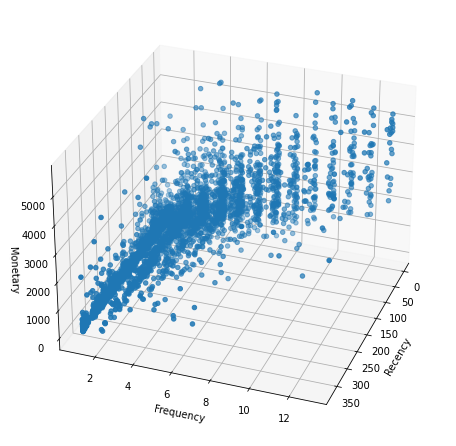

In [39]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


In [40]:
#pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('pca', decomposition.PCA(n_components=2))])
scaler = preprocessing.StandardScaler()
pca = decomposition.PCA(n_components=2)
rfm_scaler = scaler.fit_transform(rfm_table_cleaned)
pca.fit(rfm_scaler)
rfm_table_processed = pca.transform(rfm_scaler)

var_exp = pca.explained_variance_ratio_
rfm_table_processed = pd.DataFrame(rfm_table_processed)
rfm_table_processed

,0,1
0,-2.135201,1.401596
1,3.447125,0.852872
2,0.629103,0.083217
3,0.152932,-0.720954
4,-1.888765,1.382645
...,...,...
4039,-0.873840,-0.729007
4040,-1.805975,1.051772
4041,-1.421026,0.168347
4042,-0.319330,-1.198285


<AxesSubplot:xlabel='0', ylabel='1'>

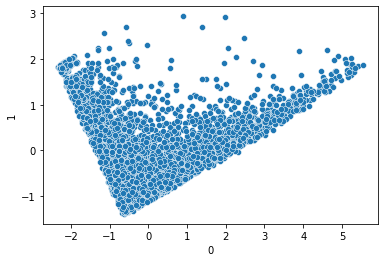

In [41]:
sns.scatterplot(data=rfm_table_processed, x=0, y=1)

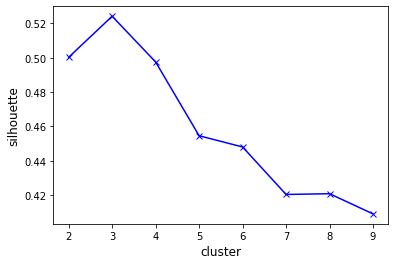

In [42]:
def get_silhouette(cluster_num, X):
    k_means = cluster.KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
    silhouette = metrics.silhouette_score(X, k_means.labels_, metric='euclidean')
    return silhouette

silhouettes = []
for i in range(2, 10):
    silhouettes.append(get_silhouette(i, rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 10)], silhouettes, 'xb-')

0.34248405083913785
0.43606149772658104
0.3501027804470042
0.2469692468901788
0.2666696444349457
0.19885132009228115
0.1968798017230573
0.157626518068815


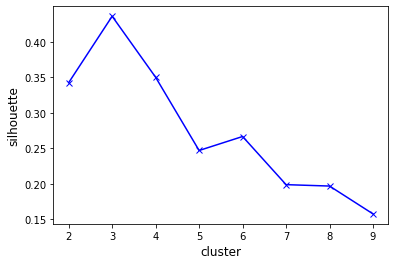

In [43]:
def get_silhouette(cluster_num, X):
    em = mixture.GaussianMixture(n_components=cluster_num, random_state=42)
    em.fit(X)
    em_labels=em.predict(X)
    em_labels.shape
    silhouette = metrics.silhouette_score(X, em_labels)
    return silhouette, print(silhouette.max())

silhouettes = []
for i in range(2, 10):
    silhouettes.append(get_silhouette(i, rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 10)], silhouettes, 'xb-')

In [44]:
k_means =  cluster.KMeans(n_clusters=3, random_state=42)
k_means.fit(rfm_table_processed)

clus = k_means.predict(rfm_table_processed)

In [45]:
clus = pd.DataFrame(clus)
clus.value_counts()

2    2269
0     999
1     776
dtype: int64

In [46]:
rfm_table_processed['labels'] = clus

Визуализируем результаты кластеризации:

<AxesSubplot:xlabel='0', ylabel='1'>

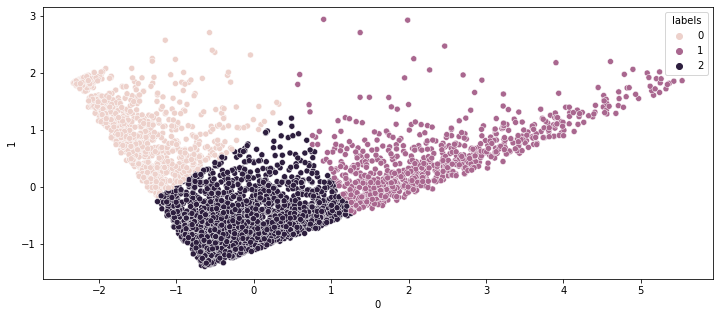

In [47]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x=0, 
    y=1, 
    hue='labels',
)

Итак, у нас есть три сегмента клиентов. Попробуем составить профиль для этих сегментов.

In [48]:
rfm_table_cleaned_copy = rfm_table_cleaned.copy()
rfm_table_cleaned_copy = rfm_table_cleaned_copy.reset_index().join(clus).rename({0: 'Clusters'}, axis=1)
rfm_table_cluster = rfm_table_cleaned_copy.groupby('Clusters')[['Recency', 'Frequency', 'Monetary']].mean()
rfm_table_cluster

,Recency,Frequency,Monetary
Clusters,,,
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947


In [49]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

In [50]:
plot_cluster_profile(rfm_table_cluster, 3)

## 6. RFM-сегментация клиентов: часть 2

In [51]:
#pipe = pipeline.Pipeline([('scaler', preprocessing.StandardScaler()), ('tsne', manifold.TSNE(perplexity=50, random_state=100))])
scaler = preprocessing.StandardScaler()
tsne = manifold.TSNE(perplexity=50, random_state=100)
rfm_scaler = scaler.fit_transform(rfm_table_cleaned)
tsne.fit(rfm_scaler)
rfm_table_processed = tsne.fit_transform(rfm_scaler)

tsne.kl_divergence_

0.5415281057357788

In [52]:
rfm_table_processed = pd.DataFrame(rfm_table_processed)
rfm_table_processed

,0,1
0,-5.096237,32.750000
1,19.839493,30.269058
2,30.227396,-1.920902
3,9.074645,-19.684454
4,-8.583499,27.215914
...,...,...
4039,-49.173233,-9.688798
4040,-16.750748,29.568644
4041,-39.459114,14.812618
4042,-8.486209,-42.226669


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


<AxesSubplot:xlabel='0', ylabel='1'>

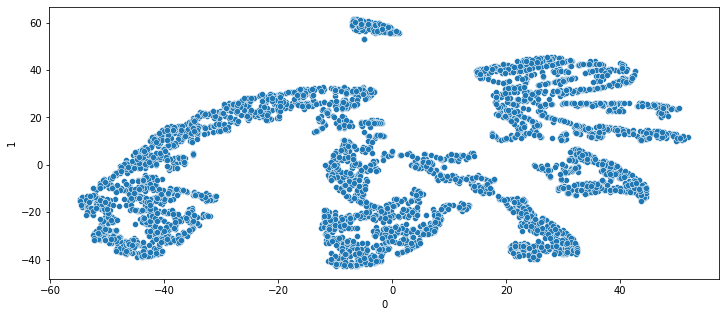

In [53]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x=0, y=1)

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

0.4341887
0.47927818
0.47802824
0.47919554
0.4844949
0.48202553


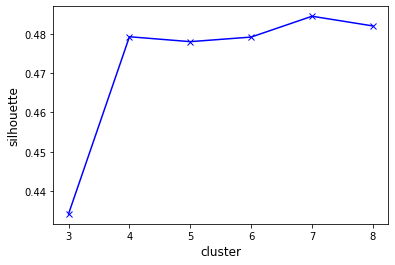

In [54]:
def get_silhouette(cluster_num, X):
    k_means = cluster.KMeans(n_clusters=cluster_num, random_state=42)
    k_means.fit(X)
    silhouette = metrics.silhouette_score(X, k_means.labels_, metric='euclidean')
    return silhouette, print(silhouette.max())

silhouettes = []
for i in range(3, 9):
    silhouettes.append(get_silhouette(i, rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouettes, 'xb-')

0.42707106
0.46882698
0.41234663
0.45716244
0.41188315
0.42917278


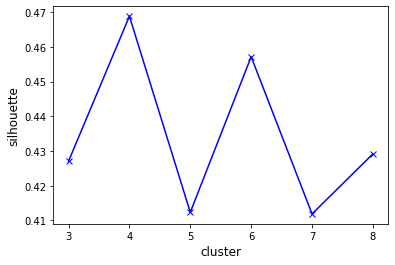

In [55]:
def get_silhouette(cluster_num, X):
    em = mixture.GaussianMixture(n_components=cluster_num, random_state=42)
    em.fit(X)
    em_labels=em.predict(X)
    em_labels.shape
    silhouette = metrics.silhouette_score(X, em_labels)
    return silhouette, print(silhouette.max())

silhouettes = []
for i in range(3, 9):
    silhouettes.append(get_silhouette(i, rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(3, 9)], silhouettes, 'xb-')

0.37970987
0.42311588
0.45664746
0.47039407
0.46917537
0.45863596
0.4790458


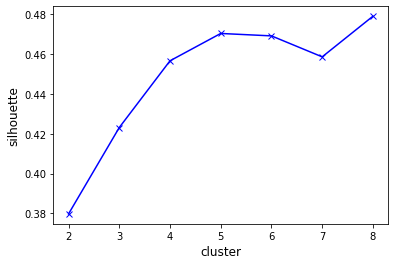

In [56]:
def get_silhouette(cluster_num, X):
    ag = cluster.AgglomerativeClustering(n_clusters=cluster_num)
    ag.fit(X)
    silhouette = metrics.silhouette_score(X, ag.labels_, metric='euclidean')
    return silhouette, print(silhouette.max())

silhouettes = []
for i in range(2, 9):
    silhouettes.append(get_silhouette(i, rfm_table_processed))
    
plt.xlabel("cluster", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.plot([i for i in range(2, 9)], silhouettes, 'xb-')

In [57]:
k_means = cluster.KMeans(n_clusters=7)
k_means.fit(rfm_table_processed)
silhouette = metrics.silhouette_score(rfm_table_processed, k_means.labels_, metric='euclidean')
print(silhouette.max())

clusters_for_kmeans = k_means.predict(rfm_table_processed)

0.49480283


In [58]:
clusters_for_kmeans_df = pd.DataFrame(clusters_for_kmeans)
clusters_for_kmeans_df.value_counts()

0    914
4    776
5    682
3    606
1    530
6    422
2    114
dtype: int64

Визуализируем результаты кластеризации:

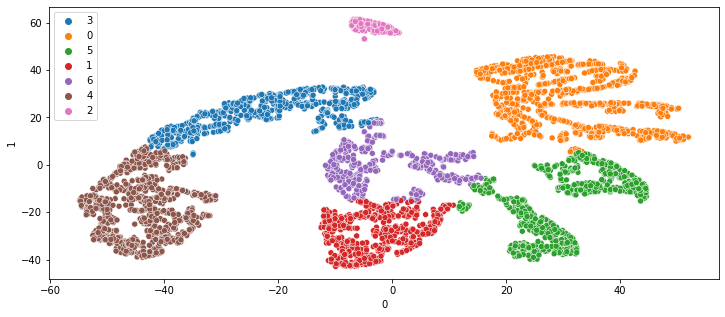

In [59]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x=0, y=1, hue=k_means.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Составим профиль для этих сегментов. 


In [60]:
rfm_table_cleaned_copy = rfm_table_cleaned.copy()
rfm_table_cleaned_copy = rfm_table_cleaned_copy.reset_index().join(clusters_for_kmeans_df).rename({0: 'Clusters'}, axis=1)
rfm_table_cluster = rfm_table_cleaned_copy.groupby('Clusters')[['Recency', 'Frequency', 'Monetary']].mean()
rfm_table_cluster

,Recency,Frequency,Monetary
Clusters,,,
0,32.400438,6.770241,2416.582451
1,38.583019,1.979245,600.995302
2,365.456140,1.043860,235.531930
3,251.575908,1.039604,319.697706
4,58.496134,1.000000,320.662668
5,39.736070,3.448680,996.837493
6,183.786730,2.507109,638.508081


In [61]:
plot_cluster_profile(rfm_table_cluster, 7)

## 7. RFM-кластеризация клиентов: часть 3

Сведём задачу кластеризации к задаче классификации. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

In [62]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned #очищенная RFM-таблица
y = clusters_for_kmeans_df #метки кластеров, предсказанные ранее

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_test.shape

(809, 3)

In [63]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

gs_cv = model_selection.GridSearchCV(estimator=ensemble.RandomForestClassifier(random_state=42),
                                     param_grid=param_grid,
                                     cv=5)
gs_cv.fit(X_train, y_train)
y_train_pred = gs_cv.predict(X_train)
y_test_pred = gs_cv.predict(X_test)

print('Train Accuracy on train fold: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Train Accuracy on test fold: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


Train Accuracy on train fold: 1.000
Train Accuracy on test fold: 0.986


In [64]:
print(gs_cv.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=9, random_state=42)


In [65]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

gs_cv_gbc = model_selection.GridSearchCV(estimator=ensemble.GradientBoostingClassifier(random_state=42),
                                         param_grid=param_grid,
                                         cv=5)

gs_cv_gbc.fit(X_train, y_train)
y_train_gbc_pred = gs_cv_gbc.predict(X_train)
y_test_gbc_pred = gs_cv_gbc.predict(X_test)

print('Train Accuracy on train fold: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_gbc_pred)))
print('Train Accuracy on test fold: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_gbc_pred)))

print(gs_cv_gbc.best_estimator_)

Train Accuracy on train fold: 0.999
Train Accuracy on test fold: 0.983
GradientBoostingClassifier(learning_rate=0.01, n_estimators=500,
                           random_state=42)


In [66]:
gbc = ensemble.GradientBoostingClassifier(max_depth=4, learning_rate=0.01, n_estimators=100, random_state=42)

gbc.fit(X_train, y_train)
y_train_gbc_pred = gbc.predict(X_train)
y_test_gbc_pred = gbc.predict(X_test)

print('Train Accuracy on train fold: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_gbc_pred)))
print('Train Accuracy on test fold: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_gbc_pred)))

Train Accuracy on train fold: 0.992
Train Accuracy on test fold: 0.978
